In [1]:
from InsufficientGibbs.Distribution import Normal,Gamma
from InsufficientGibbs.Models import CauchyModel

import numpy as np
import scipy
from scipy.stats import cauchy,median_abs_deviation
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pandas as pd
%load_ext autoreload
%autoreload 2

In [4]:
T=100000
t0_gibbs=time.time()
N=1001
true_x_0,true_gamma=-2,3
X=cauchy(loc=true_x_0,scale=true_gamma).rvs(size=N)
med,MAD=-2,3

loc = Normal(0,3,"$x_0$")
scale = Gamma(2,2,"$\gamma$")

Gibbs = CauchyModel(loc,scale).Gibbs_med_MAD(T,N,med,MAD,{"loc":.2,"scale":.2})
t_gibbs=time.time()-t0_gibbs

  0%|          | 7/100000 [00:00<24:14, 68.77it/s]

100%|██████████| 100000/100000 [08:30<00:00, 195.73it/s]


Acceptation rates MH : loc = 59.22% scale = 59.05% 


In [5]:
def ABC_iter(index,par):
    par_prior,t0,t_gibbs=par
    np.random.seed()
    N=1001
    if time.time()-t0<t_gibbs:
        x_0=scipy.stats.norm(loc=par_prior[0],scale=par_prior[1]).rvs(1)[0]
        gamma=np.random.gamma(shape=par_prior[2],scale=par_prior[3])
        y=scipy.stats.cauchy.rvs(loc=x_0,scale=gamma,size=N)
        med_sim,MAD_sim=np.median(y),median_abs_deviation(y)
        
        return [x_0,gamma,med_sim,MAD_sim]
    return [None,None,None,None]

In [6]:
from multiprocessing import Pool,cpu_count
from functools import partial



processes = cpu_count() # we performed our experiments on a machine with 8 cores
t0_abc=time.time()
par_prior=[0,3,2,2]
with Pool(processes) as pool:
    processed = pool.map(partial(ABC_iter, par=(par_prior,t0_abc,t_gibbs)), range(1000000))
abc=pd.DataFrame(np.array(processed).T,index=["x_0","gamma","med","MAD"]).T

shape1=abc.shape[0]
abc=abc.dropna()
print("{} NA values were dropped".format(shape1-abc.shape[0]))
abc["Dist_norm"]=((abc["med"]-med)/np.std(abc["med"]))**2+((abc["MAD"]-MAD)/np.std(abc["MAD"]))**2
abc.sort_values(by="Dist_norm",inplace=True)
abc.head()

0 NA values were dropped


,x_0,gamma,med,MAD,Dist_norm
582845,-1.826292,3.097722,-1.997597,2.998358,9.728895e-07
387548,-2.144201,2.787197,-2.001637,2.997151,1.302372e-06
491693,-2.155725,3.335364,-2.000258,2.993489,5.261307e-06
768033,-1.923556,2.992260,-1.999364,3.007105,6.301256e-06
985056,-2.141760,2.892574,-2.006041,2.995637,6.396538e-06


In [10]:
import os 
os.getcwd()

'/Users/antoineluciano/Documents/Recherche/Insufficient-Gibbs-Sampling/src/InsufficientGibbs'

ABC epsilon = 0.21668817582559663


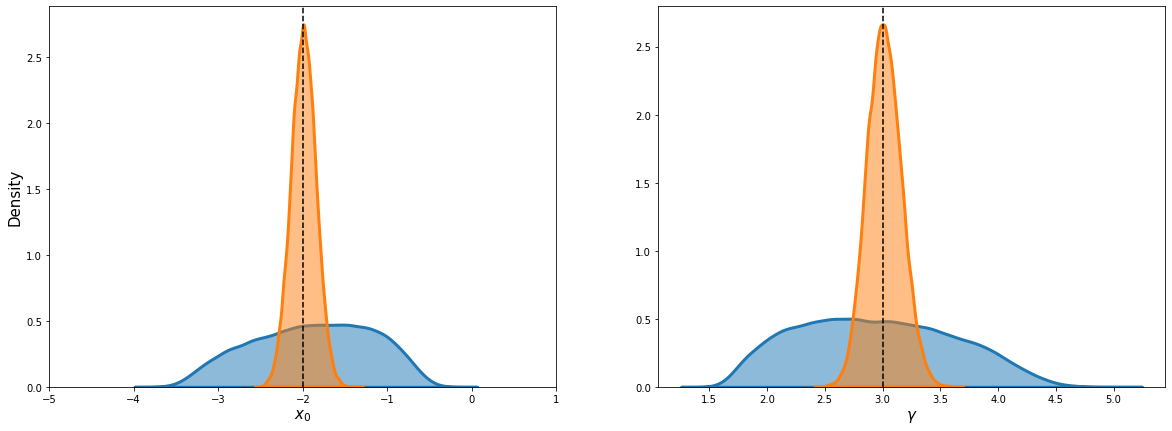

In [14]:
T=100000
epsilon=abc["Dist_norm"].iloc[T]
print("ABC epsilon =",epsilon)

f,ax=plt.subplots(1,2,figsize=(20,7))

sns.kdeplot(abc["x_0"].iloc[:T],label="ABC",ax=ax[0],fill=True,alpha=0.5,lw=3)
sns.kdeplot(Gibbs["chains"]["loc"],label="Gibbs",ax=ax[0],fill=True,alpha=0.5,lw=3)

x=np.linspace(np.min(abc["x_0"].iloc[:T]),np.max(abc["x_0"].iloc[:T]),1000)
ax[0].axvline(x=true_x_0,color="black",label="True value",linestyle="--")
ax[0].set_xlabel("$x_0$",fontsize=15)
ax[0].set_xlim([true_x_0-true_gamma,true_x_0+true_gamma])
ax[0].set_ylabel("Density",fontsize=15)
sns.kdeplot(abc["gamma"].iloc[:T],label="ABC",ax=ax[1],fill=True,alpha=0.5,lw=3)
sns.kdeplot(Gibbs["chains"]["scale"],label="Gibbs",ax=ax[1],fill=True,alpha=0.5,lw=3)

x=np.linspace(np.min(abc["gamma"].iloc[:T]),np.max(abc["gamma"].iloc[:T]),1000)
ax[1].axvline(x=true_gamma,color="black",label="True value",linestyle="--")
ax[1].set_xlabel("$\gamma$",fontsize=15)
ax[1].set_ylabel("",fontsize=15)

# plt.savefig("Fig5.png", format = "png", bbox_inches='tight', dpi=500)
# plt.savefig("Fig5.pdf", format = "pdf", bbox_inches='tight', dpi=500)
# plt.legend()